In [1]:
# Created on 4/5/22 at 2:01 PM 

# Author: Jenny Sun
# Created on 4/5/22 at 12:44 PM

# Author: Jenny Sun
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 8
import numpy as np
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
import pickle
from notebook.services.config import ConfigManager

# configurate fonts
plt.rcParams.update({'font.size': 17})

# set up file
onlyfile = [f for f in listdir('data') if (('111' in f) or ('111' in f)) and ('csv' in f)]
onlyfile.sort()

# concat all the csv files
df = []
for f in onlyfile:
    df.append(pd.read_csv('data/' + f))

condPerBlock=[]
for d in df:
    condPerBlock.append(d['stimDur'].unique())

df = pd.concat(df)

def loadPKL(filename):
    myfile = open(filename, 'rb')
    f = pickle.load(myfile)
    return f


In [2]:
# get rid of trials without any respones

df['time'].replace('[]',np.nan, inplace =True)
print('% of null trials:', sum(df['time'].isnull()) / len(df) )
df_1 = df[df['time'].notnull()]

# unique conditions
stimDur= df_1['stimDur'].unique()
stimDur.sort()


% of null trials: 0.019736842105263157


In [3]:
# get important arrays
def getAllArrays(df_1):
    allData = {}
    rt = np.array(df_1['time'].astype('float'))
    count = np.array(df_1['count'])

    # clean the data
    key = []
    sequence = []
    stimDur = []

    for index, row in df_1.iterrows():
        if row['key'] == "[5]":
            k = 1
        else:
            k = 0
        key.append(k)
        seq = row['sequence'].split(".")
        l = []
        for i in seq:
            i = i.replace("[", '')
            i = i.replace("]", '')
            if '1' in i:
                l.append(int(i))
        sequence.append(l)
        stimDur.append(row['stimDur'])
    key = np.array(key)
    sequence = np.array(sequence)
    stimDur = np.array(stimDur)
    allData = {'rt':rt, 'count': count, 'key':key, 'sequence': sequence, 'stimDur': stimDur}
    return allData

In [4]:
allData = getAllArrays(df_1)
def getDict(allData, dur=0.2):
    condData = {}
    # index the conditions
    trialind = allData['stimDur']==dur
    rt_ = allData['rt'][trialind]
    key_= allData['key'][trialind]
    count_ = allData['count'][trialind]
    sequence_ = allData['sequence'][trialind]

    cumsum = np.cumsum(sequence_,axis=1)   # random walk of the sequence


    sequence_stop =[]   # sequence stopping at the 
    cumsum_stop = []  # random walk when sequence stops
    maxind = []     # index of max evidence    
    direction = []  # direction of the max ind, O is 1 and X is 0 
    maxvalue = []   # value at the max evidenc
    boundary = []   # value upon stop
    for r in range(0,len(sequence_)):
        s = sequence_[r][0:count_[r]+1-1]
        sequence_stop.append(s)
        c = np.cumsum(s)
        maxind.append(np.argmax(np.abs(c)))
        cumsum_stop.append(c)
        boundary.append(c[-1:])
        maxvalue.append(c[maxind[-1]])
        if c[maxind[-1]] < 0:
            direction.append(0)
        else:
            direction.append(1)
    direction=np.array(direction)
    maxvalue = np.array(maxvalue)
    boundary = np.squeeze(np.array(boundary))
    maxind = np.array(maxind)
    condData = {'trialind':trialind, 'rt_':rt_, 'key_':key_, 'count_':count_,
               'sequence_':sequence_, 'cumsum':cumsum, 'sequence_stop':sequence_stop,
               'cumsum_stop':cumsum_stop, 'maxind':maxind, 'direction':direction,'maxvalue':maxvalue,
               'boundary':boundary}
    return condData,dur






In [13]:
## plotting function
def plot_sorted(d,dur):
    # sorting ind
    rt_ind = np.argsort(d['rt_'])   # sort by rt from fastest to slowest
    boundary_ind = np.argsort(d['boundary']) # sort from lowest boundary to highest
    maxvalue_ind = np.argsort(np.abs(d['maxvalue']))
    fig, ax = plt.subplots(1, figsize=(14,20))

    for p in np.unique(np.abs(d['maxvalue'])):
        ind_p = np.abs(d['maxvalue']) == p
        acc = d['direction'] ==d['key_']
        acc_p=acc[ind_p]
        maxind_p = d['maxind'][ind_p]
        count_p = d['count_'][ind_p]
        maxind_sort = np.argsort(maxind_p)
        maxind_p = maxind_p[maxind_sort]
        count_p = count_p[maxind_sort]
    #     print(sum(count_p>maxind_p) == len(count_p))
        acc_p = acc_p[np.argsort(maxind_p)]
        yvec =  np.linspace(p-0.2, p+0.7,len(maxind_p))
        a = ax.plot(maxind_p, yvec,'^')
        col = a[0].get_color()
        ax.plot(count_p,yvec,'o', color=col)
        ax.set_xticks(np.arange(1,31))

        for i in range(0, len(acc_p)):
            x1 = maxind_p[i]
            x2= count_p[i]
            if acc_p[i]:
                ax.plot((x1,x2),(yvec[i], yvec[i]), ls = '-',color = col)
            else: 
                ax.plot((x1,x2),(yvec[i], yvec[i]), ls = '--',color = col)
        ax.grid(visible=True, axis='x', linestyle='-')

        ax.set_ylabel('Magnitude of Peak Evidence before the  Display at Reponse')
        ax.set_xlabel('Number of Stimuli')
        plt.title('Stimulus Duration Per Display: %s ms'%dur)

In [14]:
def plot_max_boundary(d,dur):
    fig,ax = plt.subplots(1, figsize=(10,10))
    maxvalue = d['maxvalue']
    boundary = d['boundary']
    ax.scatter(maxvalue, boundary)
    ax.set_xticks(np.arange(-max(np.abs(maxvalue)), max(np.abs(maxvalue)),2))
    ax.set_xlabel('Maximum evidence of the Chain Before Response')
    ax.set_ylabel('Level of evidence at Response')
    plt.title('Stimulus Duration Per Display: %s ms \n 0 Mean No Evidence'%dur )

In [15]:
for stim in stimDur:
    print(stim)

0.1
0.2
0.5


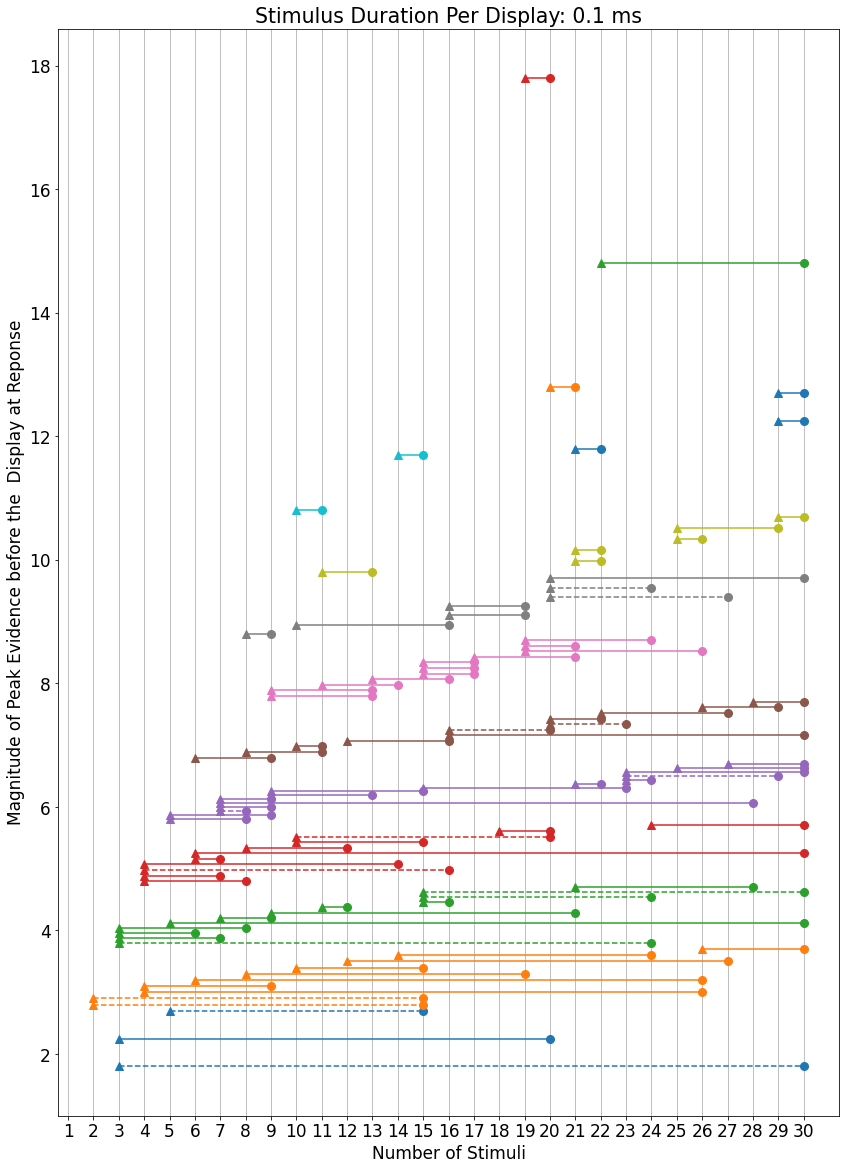

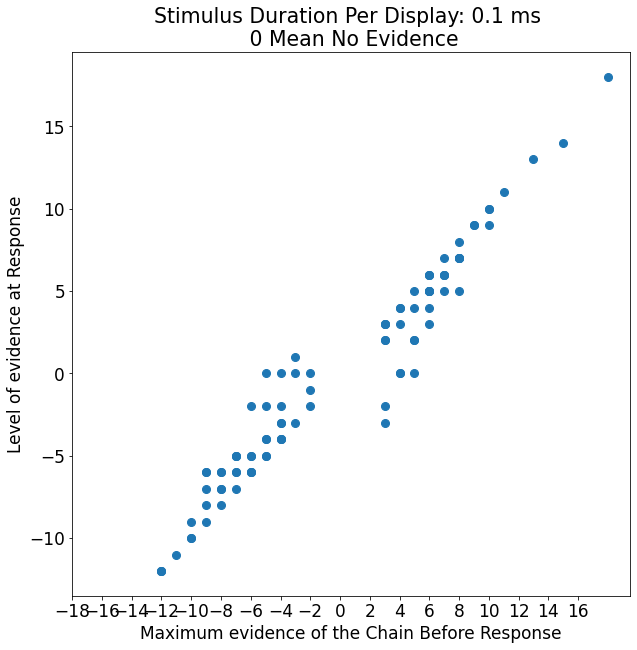

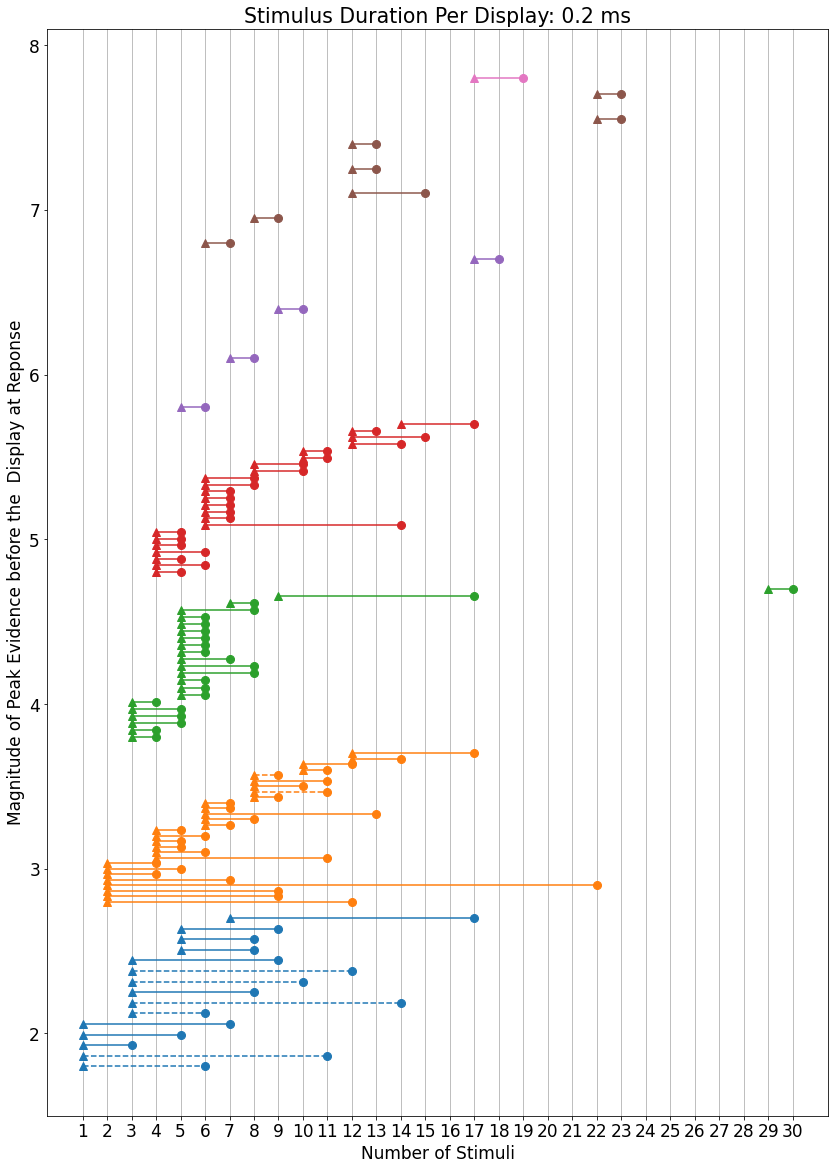

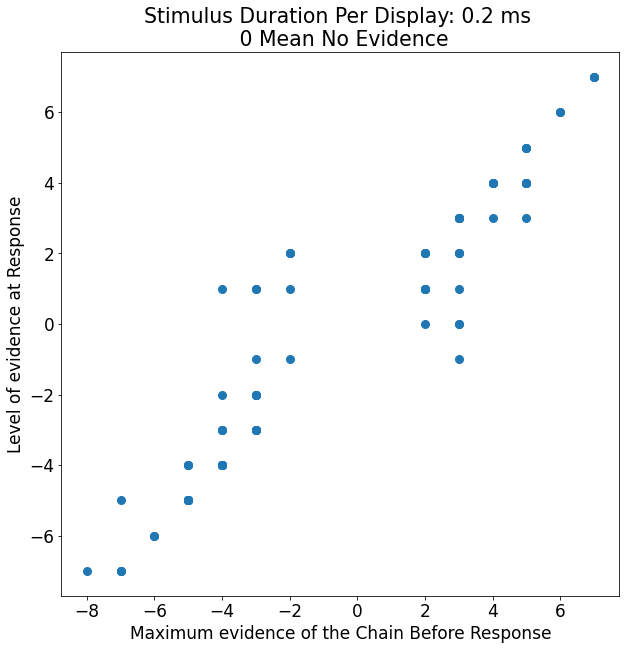

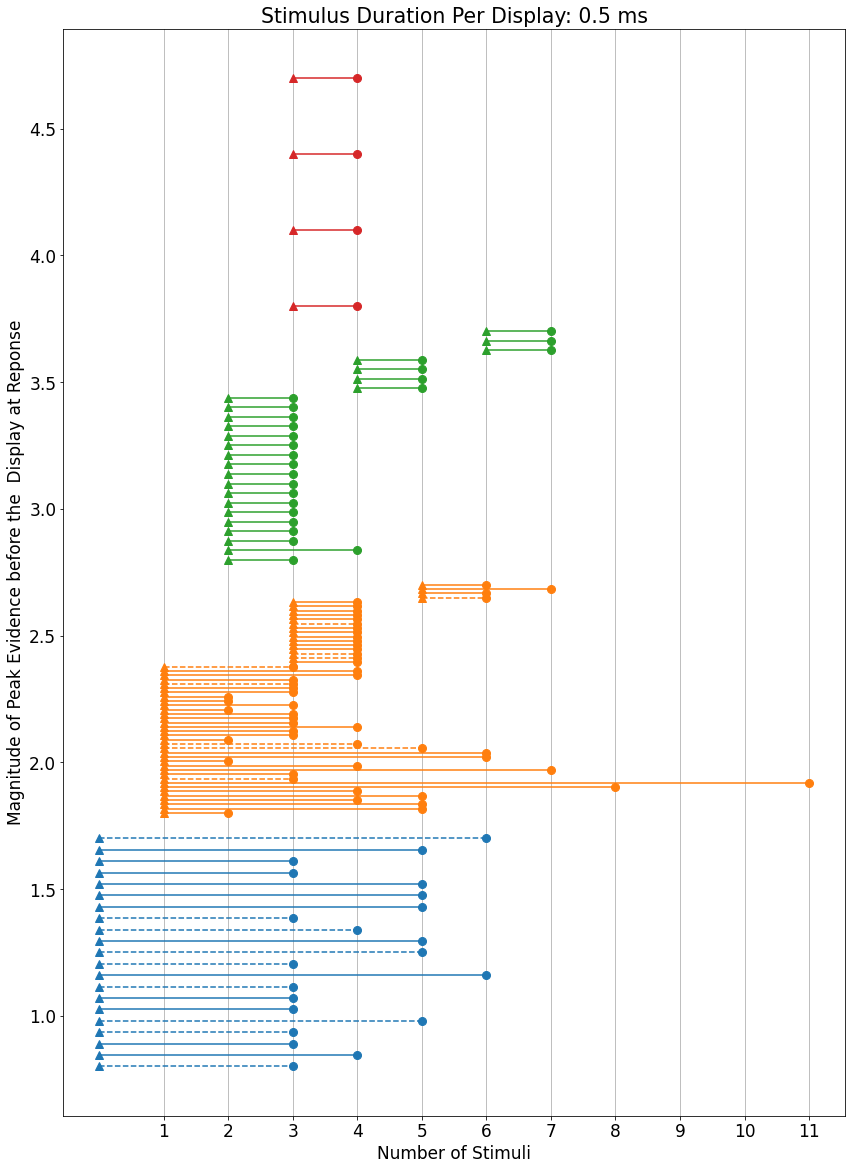

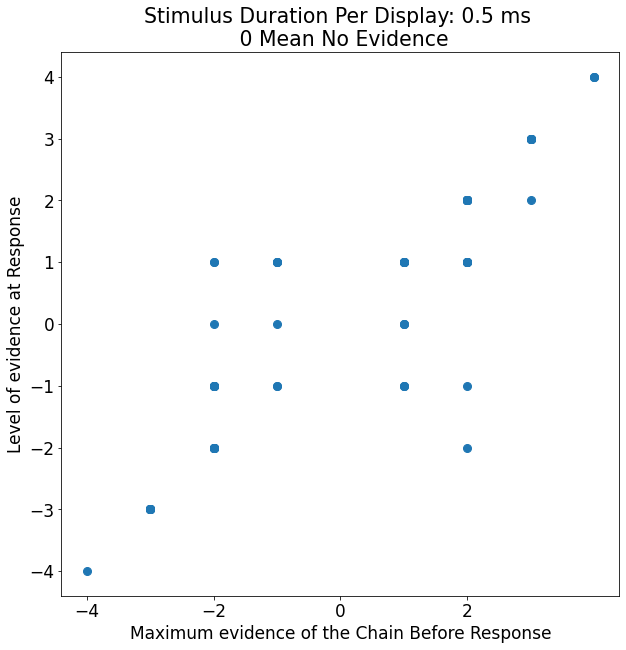

In [16]:
for stim in stimDur:
    d,dur = getDict(allData,dur=stim)
    plot_sorted(d,dur)
    plot_max_boundary(d,dur)
